In [1]:
import signal
import time
import sys
import numpy as np
import matplotlib.pyplot as plt

"""Task 1.1
 -> Implementation of the GAME
"""
class TicTacToe:
    # Game params
    continue_to_play = True
    count_games = 0
    count_wins = []
    symbols = {1: 'x',
               -1: 'o',
               0: ' '}

    USER_GAMES = 1
    AI_GAMES = 1000
    # Root game
    ROOT_GAME = np.zeros((3, 3), dtype=int)
    # Init game
    game_state = ROOT_GAME
    # V(s) hash-table
    V_s = {np.array_str(game_state): np.ones(9) * 0.1}

    # Other params
    original_sigint = None

    def __init__(self):
        # store the original SIGINT handler
        self.original_sigint = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.exit_gracefully)

    def exit_gracefully(self, signum, frame):
        # restore the original signal handler as otherwise evil things will happen
        # in raw_input when CTRL+C is pressed, and our signal handler is not re-entrant
        signal.signal(signal.SIGINT, self.original_sigint)

        try:
            if input("\nReally quit? (y/n)> ").lower().startswith('y'):
                self.continue_to_play = False

        except KeyboardInterrupt:
            print("Ok ok, quitting")
            sys.exit(1)

        # restore the exit gracefully handler here
        signal.signal(signal.SIGINT, self.exit_gracefully)

    def move_still_possible(self, current_game):
        return not (current_game[current_game == 0].size == 0)

    def move_o(self, current_game):
        ys, xs = np.where(current_game == 0)
        # generate random movement
        i = np.random.permutation(np.arange(ys.size))[0]
        # save movement
        current_game[ys[i], xs[i]] = -1

        return current_game

    def move_x(self, current_game, count):
        ys, xs = np.where(current_game == 0)
        valid = False

        # first 10 games, play by selection
        if count < self.USER_GAMES:
            while(not valid):
                value = -1
                try:
                    value = int(input("Make a move: "))
                except Exception as e:
                    print()
                    print("Please insert a number")
                    continue

                if value not in range(1, 10):
                    print("Please insert a number between 1 and 9")
                    continue

                i = value - 1
                x = i % 3
                y = i // 3

                if current_game[y, x] == 0:
                    current_game[y, x] = 1
                    valid = True
                else:
                    valid_poses = [(ys[i] * 3 + xs[i]) +
                                   1 for i in range(ys.size)]
                    print("Invalid move, the valid poses are:")
                    print(sorted(valid_poses))

        # played by AI
        else:
            # AI choice
            # Task 1.4 - Automated procedure selection
            if np.random.random_sample(1) > 0.1:
                V_s_values = self.V_s[np.array_str(current_game)]
                valid_poses = [ys[i] * 3 + xs[i] for i in range(ys.size)]

                max_v = -np.inf
                i = -1

                for k in range(V_s_values.size):
                    if (V_s_values[k] > max_v and k in valid_poses):
                        max_v = V_s_values[k]
                        i = valid_poses.index(k)

                current_game[ys[i], xs[i]] = 1

            # Rand choice
            else:
                i = np.random.permutation(np.arange(ys.size))[0]
                current_game[ys[i], xs[i]] = 1

        return current_game, i

    def move_was_winning_move(self, current_game, player):
        if np.max((np.sum(current_game, axis=0)) * player) == 3:
            return True

        if np.max((np.sum(current_game, axis=1)) * player) == 3:
            return True

        if (np.sum(np.diag(current_game)) * player) == 3:
            return True

        if (np.sum(np.diag(np.rot90(current_game))) * player) == 3:
            return True

        return False

    # print game state matrix using characters

    def print_game_state(self, current_game):
        B = np.copy(current_game).astype(object)
        for n in [-1, 0, 1]:
            B[B == n] = self.symbols[n]
        print(B)

    def learning_algo(self, tracker, last_move, last_score):
        # Tracker length
        n_movements = len(tracker) - 1

        # Traverse tracker in reverse order
        for x in range(n_movements, -1, -1):
            # Update terminal state V(s)
            if (x == n_movements):
                self.V_s[np.array_str(tracker[x])][last_move] = last_score
                continue
            
            theta = max(min(((9 - x) / 6) * 0.2, 0.2), 0.05)

            # Update previous states V(s)
            # Task 1.3 - Implementation of the update formula
            self.V_s[np.array_str(tracker[x])] = (self.V_s[np.array_str(
                tracker[x])] + theta * (self.V_s[np.array_str(tracker[x+1])] - self.V_s[np.array_str(tracker[x])]))

    def show_statistics(self):
        freq = []
        for x in range(0, len(self.count_wins), 100):
            freq.append(self.count_wins[x-100:x].count(1) / 100)

        plt.plot(freq)
        plt.ylabel('Win ratio')
        plt.show()

    def run(self):

        # First game state initialization
        self.game_state = np.zeros((3, 3), dtype=int)
        # V(s) hash-table
        self.V_s = {np.array_str(self.game_state): np.ones(9) * 0.1}

        # Game variable
        self.count_games = 0
        self.count_wins = []

        while(self.continue_to_play):

            if self.count_games > self.AI_GAMES + self.USER_GAMES:
                self.continue_to_play = False
                continue

            # initialize an empty tic tac toe board
            self.game_state = np.zeros((3, 3), dtype=int)
            # Last player before terminal state
            last_move = None
            last_score = 0

            # initialize the player who moves first (either +1 or -1)
            player = 1

            # initialize a move counter
            mvcntr = 1

            # initialize a flag that indicates whetehr or not game has ended
            noWinnerYet = True

            # State tracker
            tracker = []

            # Initialize self.V_s with state0 V(s)
            tracker.append(self.game_state)
            while self.move_still_possible(self.game_state) and noWinnerYet:
                # turn current player number into player symbol
                name = self.symbols[player]
                print('%s moves' % name)

                # let current player move at random
                if player == 1:
                    self.game_state, last_move = self.move_x(
                        self.game_state, self.count_games)
                else:
                    self.game_state = self.move_o(self.game_state)

                # Check if the game state doesn't exists
                # Task 1.2 - Creation of the game state ENCODING
                # -> np.array_str(self.game_state)
                if np.array_str(self.game_state) not in self.V_s.keys():
                    # Task 1.3 - Initialize for V(s) for all states with 0.1
                    self.V_s[np.array_str(self.game_state)] = np.ones(9) * 0.1

                # Add successor state to V(s)
                tracker.append(self.game_state)

                # print current game state
                self.print_game_state(self.game_state)

                # evaluate current game state
                if self.move_was_winning_move(self.game_state, player):
                    print('player %s self.count_wins after %d moves' %
                          (name, mvcntr))
                    noWinnerYet = False
                    last_score = 1 if player == 1 else 0

                # switch current player and increase move counter
                player *= -1
                mvcntr += 1

            # Update self.V_s
            self.learning_algo(tracker, last_move, last_score)

            # Update self.count_wins when GameAI plays
            if (self.count_games > 9):
                self.count_wins.append(last_score)

            # Increase game counter
            self.count_games += 1

        if noWinnerYet:
            print('game ended in a draw')

        self.show_statistics()

In [ ]:
game = TicTacToe()
game.run()

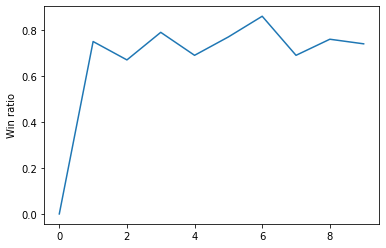

In [3]:
game.show_statistics()